In [41]:

from __future__ import print_function, division


import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import datetime
import random

import pickle

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import GradientBoostingRegressor

import ml_insights as mli


import multicat

In [2]:
rs = random.randint(1,1000)

In [3]:
df = pd.read_csv('wiki_art_clean.csv', encoding='utf-8')
df = df[df.price>1].reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296434 entries, 0 to 296433
Data columns (total 36 columns):
index                          296434 non-null int64
Unnamed: 0                     296434 non-null int64
Unnamed: 0.1                   296434 non-null int64
artist_born                    296434 non-null float64
artist_country                 296434 non-null int64
artist_died                    296434 non-null float64
fai_artist_name                296434 non-null object
medium                         296434 non-null object
price                          296434 non-null int64
size                           296434 non-null object
title                          296434 non-null object
trans_date                     296434 non-null object
wiki_artist_name               296434 non-null object
wiki_html_len                  296434 non-null int64
artist_country_name            296434 non-null object
height                         296434 non-null float64
width                       

In [4]:
cont_features = ['artist_born','trans_date_ord', 'log_area', 'log_pagerank', 
                 'log_wiki_html', 'wiki_artist_name_lpc']
X=df.loc[:,cont_features]

X = pd.concat([X, pd.get_dummies(df['medium'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['artist_country_name'])], axis=1)
X = pd.concat([X, multicat.get_dummies(df['movements'])], axis=1).to_sparse(fill_value=0)

y=df['log_price']

In [5]:
X.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 296434 entries, 0 to 296433
Columns: 233 entries, artist_born to Tonalism
dtypes: float64(23), int64(1), uint8(209)
memory usage: 17.1 MB


In [6]:
X[cont_features].describe()

,artist_born,trans_date_ord,log_area,log_pagerank,log_wiki_html,wiki_artist_name_lpc
count,296434.000000,296434.000000,296434.000000,296434.000000,296434.000000,296434.000000
mean,1868.927734,733611.576243,5.505910,-7.717059,11.529480,5.702428
std,77.973984,1242.927163,1.236258,1.455244,0.743007,1.911012
min,1245.000000,730195.000000,-2.116936,-9.545608,0.000000,0.000000
25%,1865.000000,732489.000000,4.682925,-9.274942,10.954816,4.454347
50%,1887.000000,733518.000000,5.561607,-7.769825,11.417075,5.834811
75%,1907.000000,734709.000000,6.335058,-6.416376,12.099973,6.990257
max,1960.000000,735835.000000,18.060429,-4.860392,13.775971,9.528794


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

In [8]:
lr_model1 = LinearRegression()
lr_model1.fit(X_train,y_train)
lr_model1.score(X_test, y_test)

0.49942517802314601

1.64156410565


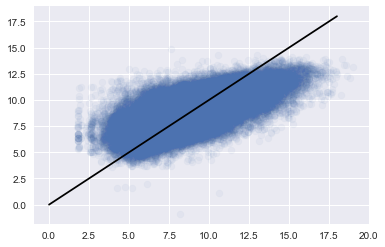

In [9]:
lr_test_pred = lr_model1.predict(X_test)

print(np.sqrt(sum((y_test - lr_test_pred)**2)/len(y_test)))

plt.scatter(y_test, lr_test_pred,alpha=.05)
plt.plot(np.linspace(0,18,1000),np.linspace(0,18,1000), color = 'k');

In [10]:
con_feature_count = len(cont_features)

#make medium rank column
medium_count = len(df.medium.unique())
medium_coef = pd.DataFrame(list(zip(X.columns, lr_model1.coef_))[con_feature_count:con_feature_count + medium_count], 
                           columns=['medium', 'coef'])

medium_coef['medium_rank'] = medium_coef.sort_values('coef', ascending=False).coef.apply(lambda x: 1).cumsum()
df = pd.merge(df, medium_coef[['medium','medium_rank']], on='medium')
#make country rank column
country_count = len(df.artist_country_name.unique())
country_coef = pd.DataFrame(list(zip(X.columns, lr_model1.coef_))
                            [con_feature_count + medium_count: con_feature_count + medium_count + country_count], 
                           columns=['artist_country_name', 'coef'])

country_coef['country_rank'] = country_coef.sort_values('coef', ascending=False).coef.apply(lambda x: 1).cumsum()
df = pd.merge(df, country_coef[['artist_country_name','country_rank']], on='artist_country_name')


# Random Forests

In [32]:
cont_features = ['artist_born', 'trans_date_ord', 'area', 'height', 'width', 
                 'wiki_artist_name_prev_count', 'medium_rank', 'country_rank', 'wiki_html_len', 'page_rank']

X=df.loc[:,cont_features]
X = pd.concat([X, multicat.get_dummies(df['movements'])], axis=1)

y=df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)


In [33]:
## To start, we will build a single tree
from sklearn import tree

# Set some parameters
#dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=4)
dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=6, min_samples_leaf=8)

# Fit the model to some training data
dtrmodel.fit(X_train,y_train)
tree.export_graphviz(dtrmodel, out_file='tree.dot',feature_names = X_train.columns)

In [34]:
rf_model = RandomForestRegressor(n_estimators = 1000, min_samples_leaf=5, max_features=15, n_jobs=-1)

rf_model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=15, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [35]:
rf_model.score(X_test,y_test)

0.73977703552870855

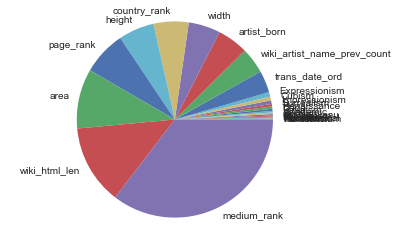

In [36]:
feat_imp = pd.DataFrame(list(zip(X_train.columns, rf_model.feature_importances_)), 
                        columns=['feature', 'importance']).sort_values('importance')
fig, ax = plt.subplots()
ax.pie(feat_imp['importance'], labels=feat_imp['feature']);
ax.axis('equal');

1.18519970178


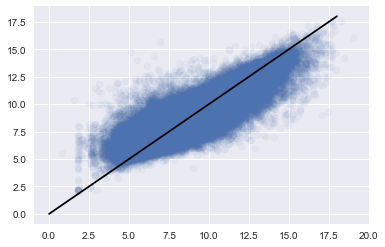

In [37]:
rf_test_pred = rf_model.predict(X_test)

plt.scatter(y_test, rf_test_pred,alpha=.05)
plt.plot(np.linspace(0,18,1000),np.linspace(0,18,1000), color = 'k')

print(np.sqrt(sum((y_test - rf_test_pred)**2)/len(y_test)))


In [38]:
mxr = mli.ModelXRay(rf_model, X_train.sample(n=500), columns=cont_features, resolution=100)

array([369, 325, 446, 429,  60])

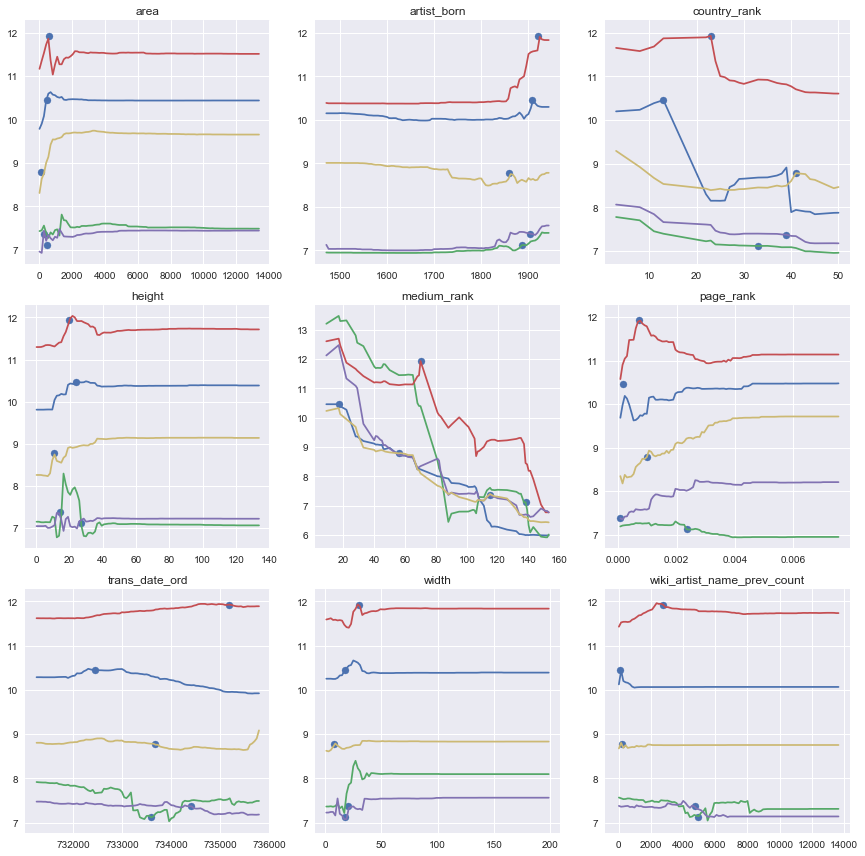

In [39]:
mxr.feature_dependence_plots(num_pts=5)

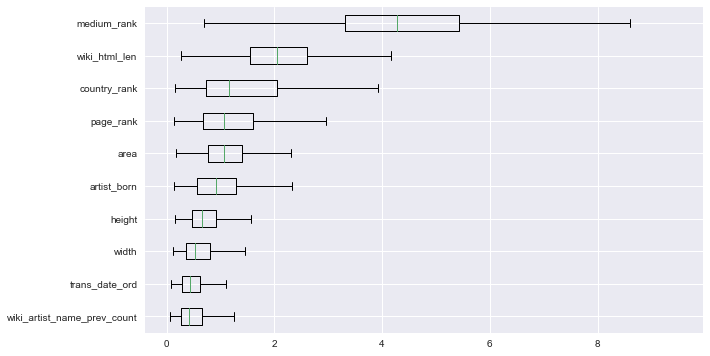

In [40]:
mxr.feature_effect_summary()

In [ ]:
gbmodel = GradientBoostingRegressor()

# Lasso model with Artist FE

In [66]:
cont_features = ['trans_date_ord', 'log_area']
X=df.loc[:,cont_features]

X = pd.concat([X, pd.get_dummies(df['medium'])], axis=1).to_sparse(fill_value=0)
X = pd.concat([X, pd.get_dummies(df['wiki_artist_name'], sparse=True)], axis=1).to_sparse(fill_value=0)


y=df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

In [67]:
alphavec = 10**np.linspace(-2,0,5)
steps = [('standardize', StandardScaler()), ('lasso', LassoCV(alphas = alphavec, cv=5))]

pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)


0.60298797371957313

1.45646603403


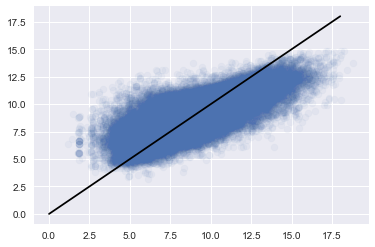

In [69]:
pipe_test_pred = pipe.predict(X_test)

plt.scatter(y_test, pipe_test_pred, alpha=.05)
plt.plot(np.linspace(0,18,1000),np.linspace(0,18,1000), color = 'k')

print(np.sqrt(sum((y_test - pipe_test_pred)**2)/len(y_test)))



In [72]:
pipe.named_steps['lasso'].alpha_

0.01